In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [3]:
df = pd.read_csv(path_csv)

In [4]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [6]:
df = df.loc[df["category"].isin(category)]

In [7]:
df = df.reset_index(drop=True)

In [8]:
sample_num = 1
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30
n_batch = 10

In [9]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/1-104089-B-22.wav


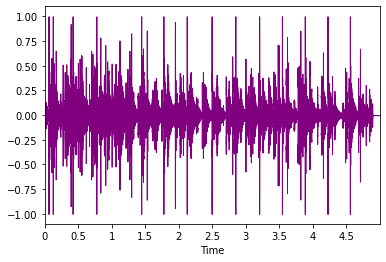

In [10]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [11]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [13]:
result = generate_features(y)

In [14]:
result.shape

(128, 480, 3)

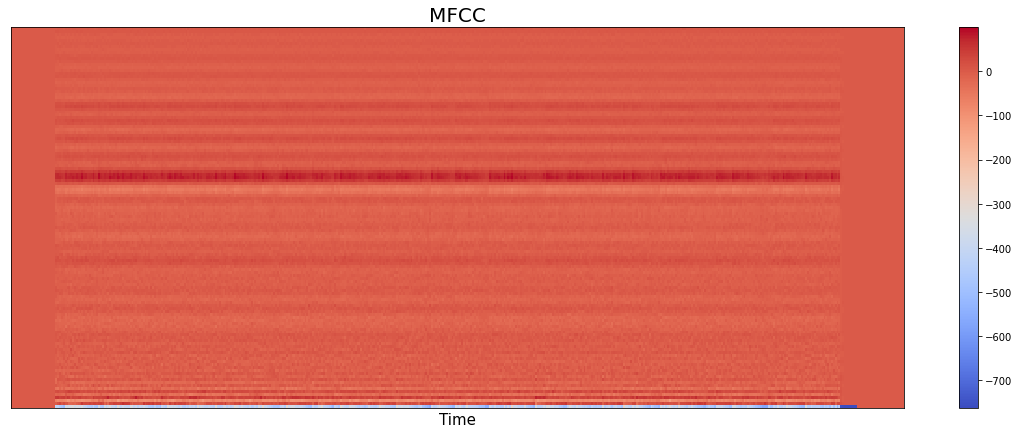

In [15]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

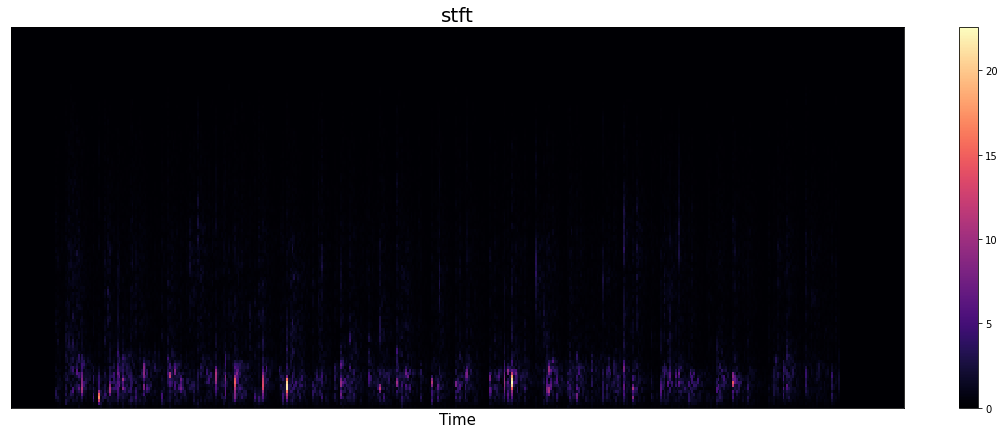

In [20]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('stft', size=20)
plt.colorbar()
plt.show()

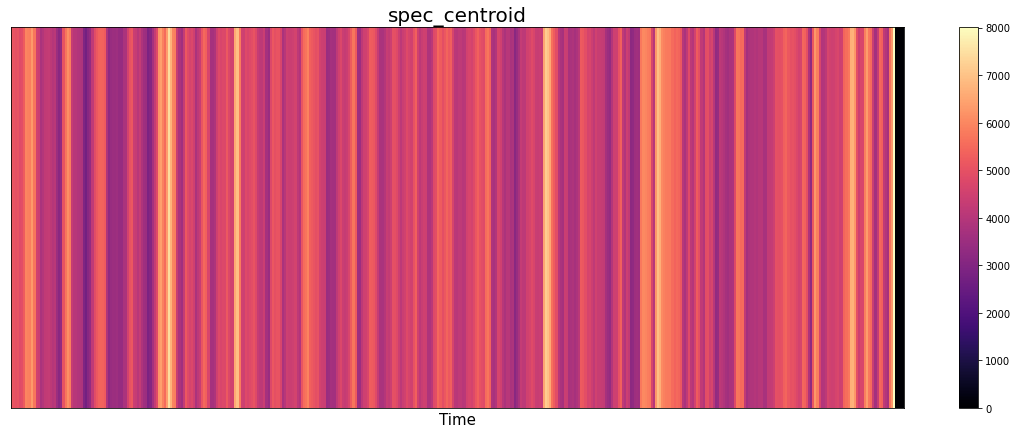

In [21]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('spec_centroid', size=20)
plt.colorbar()
plt.show()

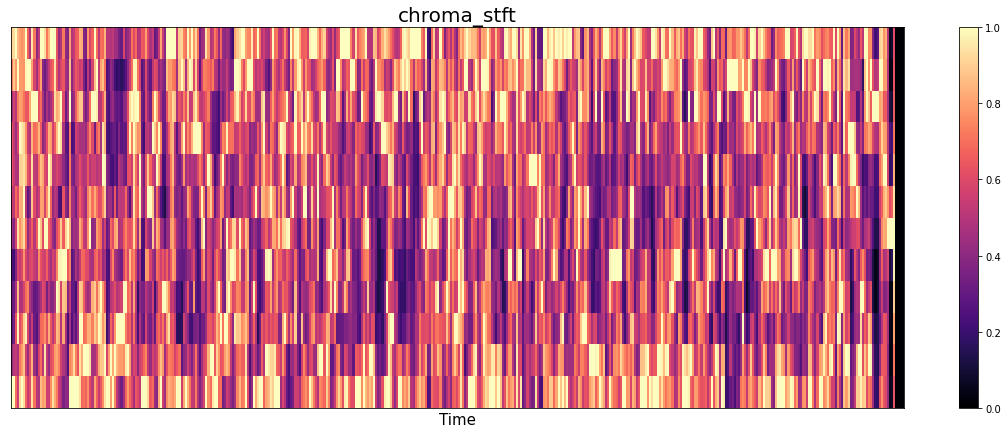

In [22]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('chroma_stft', size=20)
plt.colorbar()
plt.show()

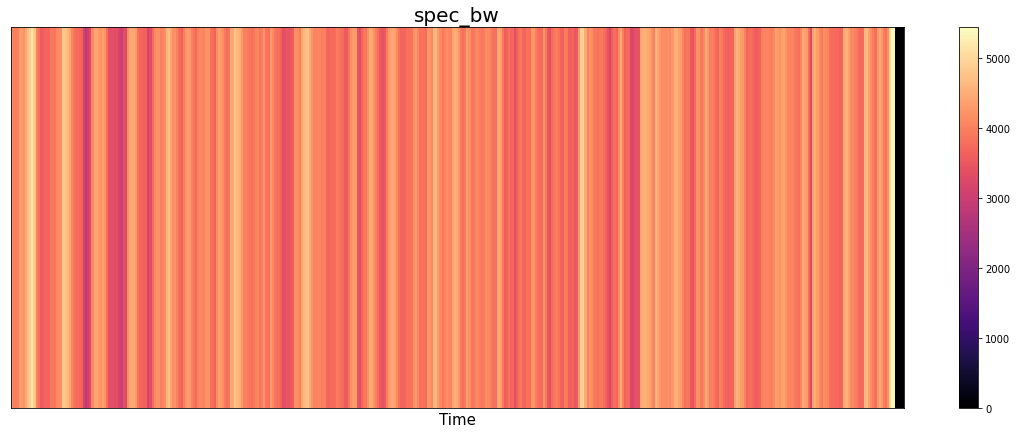

In [23]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('spec_bw', size=20)
plt.colorbar()
plt.show()

In [20]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [21]:
X, y = get_features(df, rs=(224,224))

In [22]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [23]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


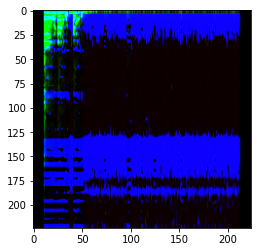

In [24]:
plt.imshow(X[144])

In [25]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [26]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# MODEL

In [38]:
from tensorflow.keras.applications import VGG19
#from tensorflow.keras.applications import Xception
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Intento 1

In [39]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-adam-VGG19-0.1.h5")

In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [41]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 177ms/step - loss: nan - accuracy: 0.1159 - val_loss: nan - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 168ms/step - loss: nan - accuracy: 0.1265 - val_loss: nan - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 168ms/step - loss: nan - accuracy: 0.0916 - val_loss: nan - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 170ms/step - loss: nan - accuracy: 0.1109 - val_loss: nan - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 171ms/step - loss: nan - accuracy: 0.1078 - val_loss: nan - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 170ms/step - loss: nan - accuracy: 0.1328 - val_loss: nan - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 169ms/step - loss: nan - accuracy: 0.0808 - val_loss: nan - val_accuracy: 0.0800
Epoch 8/30
23/23 [==============================

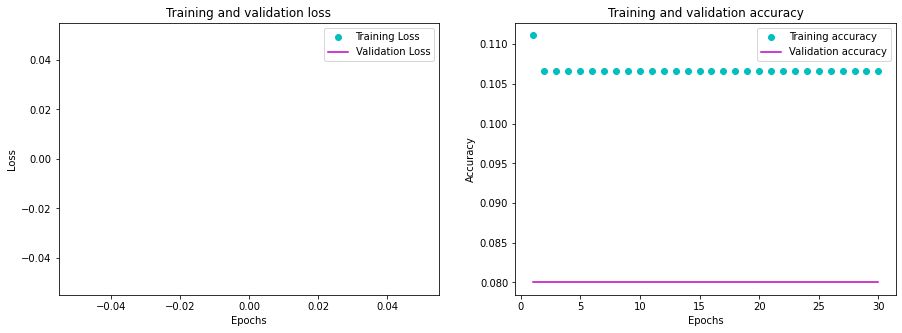

In [42]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [43]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 83ms/step - loss: nan - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [44]:
model.save("model/fit-adam-VGG19-0.1.h5")

# Intento 2 

In [45]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-adam-VGG19-0.01.h5")

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [47]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 179ms/step - loss: 5907465371648.1094 - accuracy: 0.0760 - val_loss: 276.0399 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 172ms/step - loss: 104.2967 - accuracy: 0.0884 - val_loss: 4.9331 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 173ms/step - loss: 2.9577 - accuracy: 0.0774 - val_loss: 2.3160 - val_accuracy: 0.0667
Epoch 4/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3271 - accuracy: 0.1019 - val_loss: 2.3160 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 4s 170ms/step - loss: 2.3117 - accuracy: 0.1224 - val_loss: 2.3197 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 4s 169ms/step - loss: 2.3059 - accuracy: 0.1122 - val_loss: 2.3243 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 170ms/step - loss: 2.3027 - accuracy: 0.0797 - val_loss: 2.3197 - val_accurac

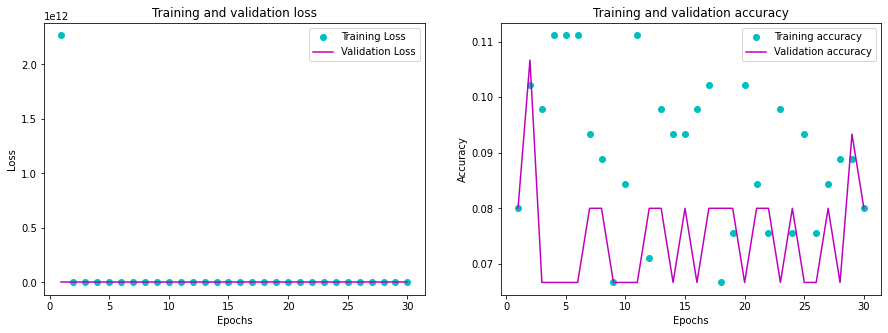

In [48]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [49]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 81ms/step - loss: 2.3083 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [50]:
model.save("model/fit-adam-VGG19-0.01.h5")

# Intento 3 

In [51]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-adam-VGG19-0.001.h5")

In [52]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [53]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 179ms/step - loss: 33.2379 - accuracy: 0.0671 - val_loss: 2.3550 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3354 - accuracy: 0.1504 - val_loss: 2.3062 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3141 - accuracy: 0.1275 - val_loss: 2.3129 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 4s 172ms/step - loss: 2.3083 - accuracy: 0.0721 - val_loss: 2.3119 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 4s 178ms/step - loss: 2.2978 - accuracy: 0.1201 - val_loss: 2.3097 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 178ms/step - loss: 2.3009 - accuracy: 0.1009 - val_loss: 2.3100 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 174ms/step - loss: 2.3021 - accuracy: 0.0902 - val_loss: 2.3110 - val_accuracy: 0.0800
Epoch

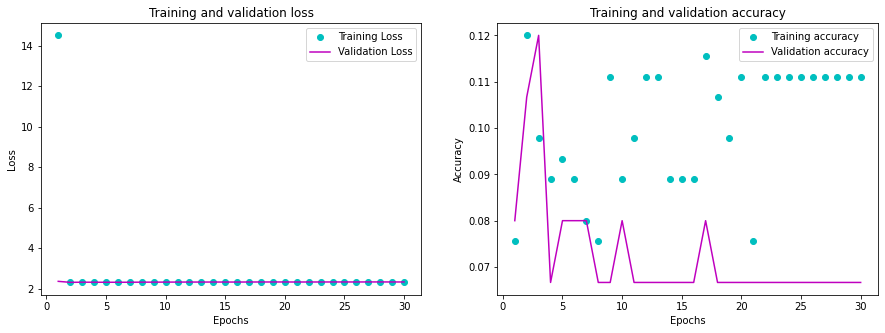

In [54]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [55]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 82ms/step - loss: 2.3056 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [56]:
model.save("model/fit-adam-VGG19-0.001.h5")

# intento 4

In [57]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-adam-VGG19-0.0001.h5")

In [58]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [59]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 180ms/step - loss: 2.8929 - accuracy: 0.0884 - val_loss: 2.3056 - val_accuracy: 0.1467
Epoch 2/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3219 - accuracy: 0.0942 - val_loss: 2.3025 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3003 - accuracy: 0.0991 - val_loss: 2.3002 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3019 - accuracy: 0.1276 - val_loss: 2.3025 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3047 - accuracy: 0.1013 - val_loss: 2.3029 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3024 - accuracy: 0.1033 - val_loss: 2.3032 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3023 - accuracy: 0.1170 - val_loss: 2.3047 - val_accuracy: 0.0800
Epoch 

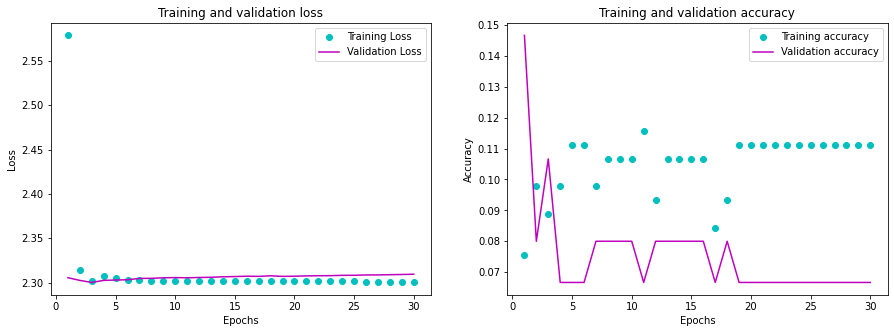

In [60]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [61]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 82ms/step - loss: 2.3030 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [62]:
model.save("model/fit-adam-VGG19-0.0001.h5")

# intento 5

In [63]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-adam-VGG19-0.00001.h5")

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [65]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 180ms/step - loss: 2.3593 - accuracy: 0.1191 - val_loss: 2.1847 - val_accuracy: 0.2267
Epoch 2/30
23/23 [==============================] - 4s 171ms/step - loss: 2.0805 - accuracy: 0.3267 - val_loss: 2.0756 - val_accuracy: 0.2800
Epoch 3/30
23/23 [==============================] - 4s 171ms/step - loss: 1.9460 - accuracy: 0.3262 - val_loss: 1.9591 - val_accuracy: 0.2400
Epoch 4/30
23/23 [==============================] - 4s 172ms/step - loss: 1.7910 - accuracy: 0.3326 - val_loss: 1.7644 - val_accuracy: 0.3467
Epoch 5/30
23/23 [==============================] - 4s 171ms/step - loss: 1.4791 - accuracy: 0.4924 - val_loss: 1.6587 - val_accuracy: 0.4267
Epoch 6/30
23/23 [==============================] - 4s 171ms/step - loss: 1.3433 - accuracy: 0.5657 - val_loss: 1.6044 - val_accuracy: 0.4533
Epoch 7/30
23/23 [==============================] - 4s 171ms/step - loss: 1.2000 - accuracy: 0.6536 - val_loss: 1.4288 - val_accuracy: 0.5067
Epoch 

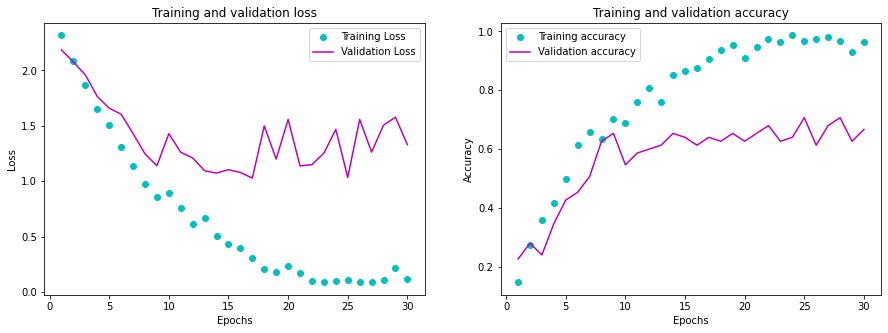

In [66]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [67]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 83ms/step - loss: 1.0838 - accuracy: 0.6900
Confusion_matrix:  tf.Tensor(
[[ 7  0  1  0  1  0  1  0  0  0]
 [ 1  8  0  0  1  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0  0]
 [ 1  0  0  4  2  0  0  1  2  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 2  0  0  0  2  3  0  1  2  0]
 [ 0  3  0  0  0  0  7  0  0  0]
 [ 0  0  0  2  0  0  0  8  0  0]
 [ 0  0  0  1  0  0  0  0  9  0]
 [ 0  2  0  0  3  1  0  0  0  4]], shape=(10, 10), dtype=int32)


In [68]:
model.save("model/fit-adam-VGG19-0.00001.h5")

# cambio de SGD

# INTENTO 1

In [69]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-SGD-VGG19-0.1.h5")

In [70]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [71]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 175ms/step - loss: nan - accuracy: 0.1009 - val_loss: nan - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 167ms/step - loss: nan - accuracy: 0.1128 - val_loss: nan - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 167ms/step - loss: nan - accuracy: 0.1199 - val_loss: nan - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 166ms/step - loss: nan - accuracy: 0.1066 - val_loss: nan - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 166ms/step - loss: nan - accuracy: 0.1021 - val_loss: nan - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 167ms/step - loss: nan - accuracy: 0.1393 - val_loss: nan - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 166ms/step - loss: nan - accuracy: 0.1084 - val_loss: nan - val_accuracy: 0.0800
Epoch 8/30
23/23 [==============================

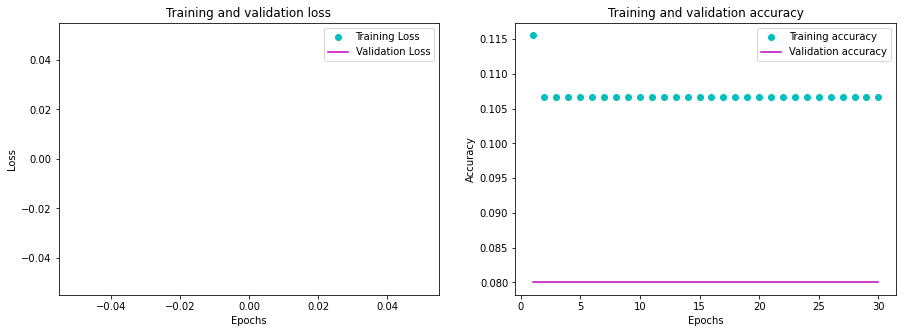

In [72]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [73]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 84ms/step - loss: nan - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [74]:
model.save("model/fit-SGD-VGG19-0.1.h5")

# INTENTO 2

In [75]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-SGD-VGG19-0.01.h5")

In [76]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [77]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 174ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 168ms/step - loss: nan - accuracy: 0.0908 - val_loss: nan - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 167ms/step - loss: nan - accuracy: 0.1069 - val_loss: nan - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 169ms/step - loss: nan - accuracy: 0.0935 - val_loss: nan - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 168ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 166ms/step - loss: nan - accuracy: 0.0992 - val_loss: nan - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 168ms/step - loss: nan - accuracy: 0.1128 - val_loss: nan - val_accuracy: 0.0800
Epoch 8/30
23/23 [==============================

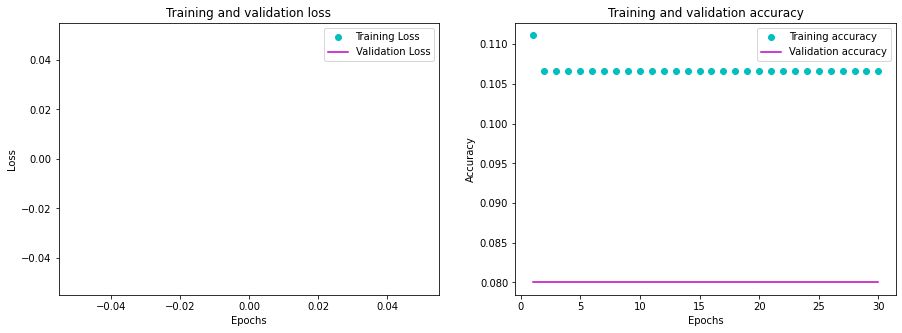

In [78]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [79]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 82ms/step - loss: nan - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [80]:
model.save("model/fit-SGD-VGG19-0.01.h5")

# INTENTO 3

In [81]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-SGD-VGG19-0.001.h5")

In [82]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [83]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 181ms/step - loss: 2.4521 - accuracy: 0.1076 - val_loss: 2.4314 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 4s 171ms/step - loss: 2.4838 - accuracy: 0.0685 - val_loss: 2.3096 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 4s 170ms/step - loss: 2.3066 - accuracy: 0.0819 - val_loss: 2.2918 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 173ms/step - loss: 2.2971 - accuracy: 0.1292 - val_loss: 2.3038 - val_accuracy: 0.1467
Epoch 5/30
23/23 [==============================] - 4s 169ms/step - loss: 2.2938 - accuracy: 0.1114 - val_loss: 2.4158 - val_accuracy: 0.0933
Epoch 6/30
23/23 [==============================] - 4s 169ms/step - loss: 2.2917 - accuracy: 0.1413 - val_loss: 2.2704 - val_accuracy: 0.2133
Epoch 7/30
23/23 [==============================] - 4s 170ms/step - loss: 2.2766 - accuracy: 0.0858 - val_loss: 2.2934 - val_accuracy: 0.1600
Epoch 

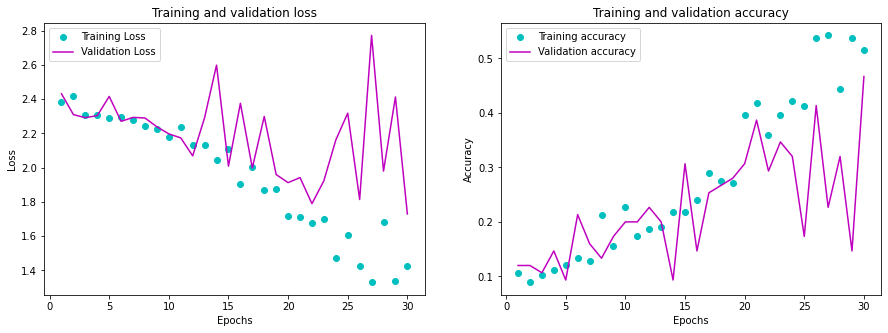

In [84]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [85]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 81ms/step - loss: 1.5844 - accuracy: 0.5300
Confusion_matrix:  tf.Tensor(
[[ 3  3  0  0  2  0  2  0  0  0]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 0  0  9  1  0  0  0  0  0  0]
 [ 0  0  0  3  2  0  0  0  5  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  3  0  0  0  0  1  0  6  0]
 [ 0  5  0  0  0  0  4  0  1  0]
 [ 0  1  1  4  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  5  0  1  0  0  0  0  3  1]], shape=(10, 10), dtype=int32)


In [86]:
model.save("model/fit-SGD-VGG19-0.001.h5")

# INTENTO 4

In [87]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-SGD-VGG19-0.0001.h5")

In [88]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [89]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 178ms/step - loss: 2.8038 - accuracy: 0.0732 - val_loss: 2.4553 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 4s 168ms/step - loss: 2.4164 - accuracy: 0.1127 - val_loss: 2.3705 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 168ms/step - loss: 2.3481 - accuracy: 0.0899 - val_loss: 2.3235 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 4s 168ms/step - loss: 2.3049 - accuracy: 0.1341 - val_loss: 2.3050 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 4s 168ms/step - loss: 2.2735 - accuracy: 0.1617 - val_loss: 2.2936 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 4s 168ms/step - loss: 2.2545 - accuracy: 0.1773 - val_loss: 2.2668 - val_accuracy: 0.1867
Epoch 7/30
23/23 [==============================] - 4s 168ms/step - loss: 2.2381 - accuracy: 0.1835 - val_loss: 2.2573 - val_accuracy: 0.2000
Epoch 

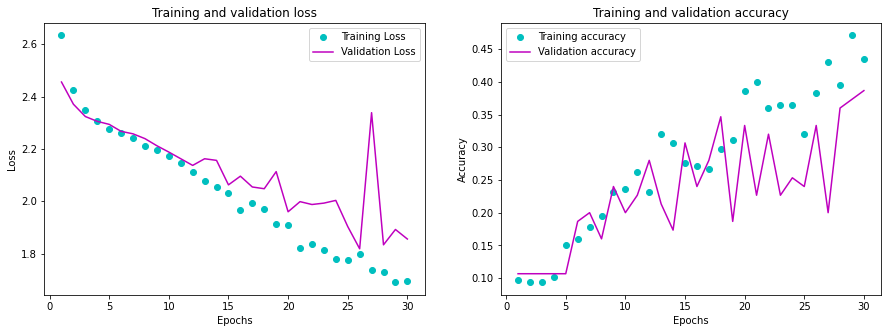

In [90]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [91]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 85ms/step - loss: 1.7641 - accuracy: 0.4100
Confusion_matrix:  tf.Tensor(
[[0 8 0 0 0 0 2 0 0 0]
 [0 9 0 0 0 0 0 0 0 1]
 [0 2 7 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 3 6 0]
 [0 4 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 5 2]
 [0 3 1 0 0 0 5 0 1 0]
 [2 1 1 0 0 0 0 2 2 2]
 [0 0 0 0 0 0 0 0 9 1]
 [0 4 0 0 0 0 2 0 1 3]], shape=(10, 10), dtype=int32)


In [92]:
model.save("model/fit-SGD-VGG19-0.0001.h5")

# INTENTO 5

In [93]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-SGD-VGG19-0.00001.h5")

In [94]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [95]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 181ms/step - loss: 2.5467 - accuracy: 0.1115 - val_loss: 2.5039 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 169ms/step - loss: 2.5521 - accuracy: 0.1252 - val_loss: 2.4866 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 171ms/step - loss: 2.4457 - accuracy: 0.1732 - val_loss: 2.4718 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 172ms/step - loss: 2.4859 - accuracy: 0.1629 - val_loss: 2.4591 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 170ms/step - loss: 2.4026 - accuracy: 0.1517 - val_loss: 2.4483 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 170ms/step - loss: 2.4617 - accuracy: 0.1031 - val_loss: 2.4387 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 4s 171ms/step - loss: 2.4314 - accuracy: 0.1225 - val_loss: 2.4307 - val_accuracy: 0.0800
Epoch 

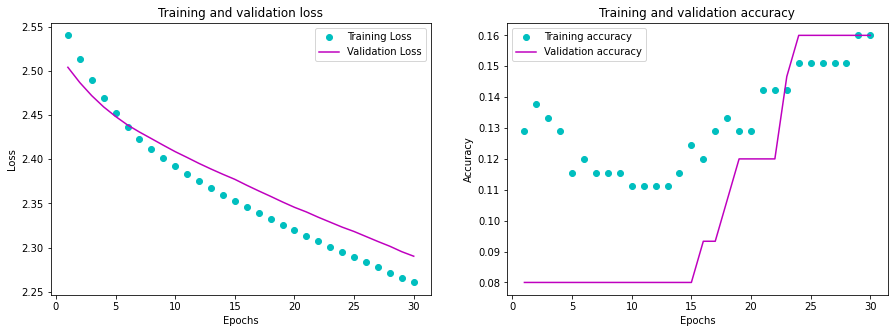

In [96]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [97]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 84ms/step - loss: 2.2733 - accuracy: 0.1500
Confusion_matrix:  tf.Tensor(
[[ 1  9  0  0  0  0  0  0  0  0]
 [ 1  9  0  0  0  0  0  0  0  0]
 [ 0  9  0  1  0  0  0  0  0  0]
 [ 2  3  0  5  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  4  0  5  0  0  0  0  0  0]
 [ 1  8  0  1  0  0  0  0  0  0]
 [ 3  5  0  2  0  0  0  0  0  0]
 [ 1  0  0  9  0  0  0  0  0  0]
 [ 4  5  0  1  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [98]:
model.save("model/fit-SGD-VGG19-0.00001.h5")

# Cambio a Adamax

# intento 1

In [99]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-Adamax-VGG19-0.1.h5")

In [100]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [101]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 180ms/step - loss: 11738911692846808208295067648.0000 - accuracy: 0.0376 - val_loss: 4496784384.0000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 4s 170ms/step - loss: 2396326272.0000 - accuracy: 0.1063 - val_loss: 159911984.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 170ms/step - loss: 283426144.6667 - accuracy: 0.1117 - val_loss: 166819136.0000 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 4s 170ms/step - loss: 67275841.9167 - accuracy: 0.1023 - val_loss: 3534546.7500 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 4s 173ms/step - loss: 901141.2318 - accuracy: 0.0967 - val_loss: 5.3249 - val_accuracy: 0.1467
Epoch 6/30
23/23 [==============================] - 4s 173ms/step - loss: 23.4055 - accuracy: 0.0832 - val_loss: 2.6471 - val_accuracy: 0.1467
Epoch 7/30
23/23 [==============================] - 4s 173m

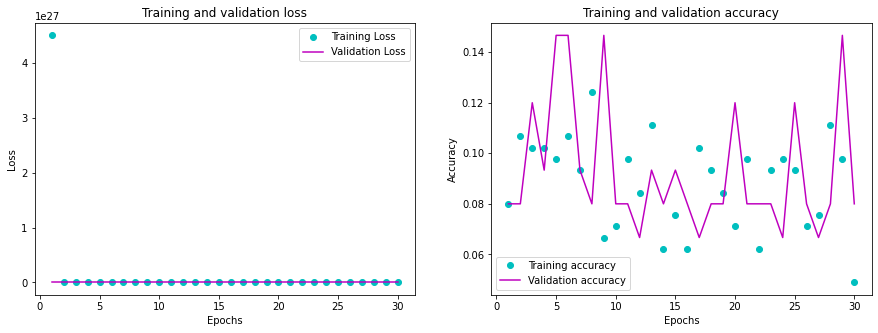

In [102]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [103]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 82ms/step - loss: 2.3054 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]], shape=(10, 10), dtype=int32)


In [104]:
model.save("model/fit-Adamax-VGG19-0.1.h5")

# intento 2

In [105]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-Adamax-VGG19-0.01.h5")

In [106]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [107]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 184ms/step - loss: 73881486185813.4219 - accuracy: 0.0541 - val_loss: 113.0752 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 4s 171ms/step - loss: 61.4566 - accuracy: 0.0845 - val_loss: 2.5776 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 4s 171ms/step - loss: 2.4958 - accuracy: 0.1029 - val_loss: 2.2906 - val_accuracy: 0.1467
Epoch 4/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3377 - accuracy: 0.0902 - val_loss: 2.2945 - val_accuracy: 0.1467
Epoch 5/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3152 - accuracy: 0.1121 - val_loss: 2.2999 - val_accuracy: 0.1467
Epoch 6/30
23/23 [==============================] - 4s 177ms/step - loss: 2.3385 - accuracy: 0.1091 - val_loss: 2.3168 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 176ms/step - loss: 2.3040 - accuracy: 0.1040 - val_loss: 2.3235 - val_accurac

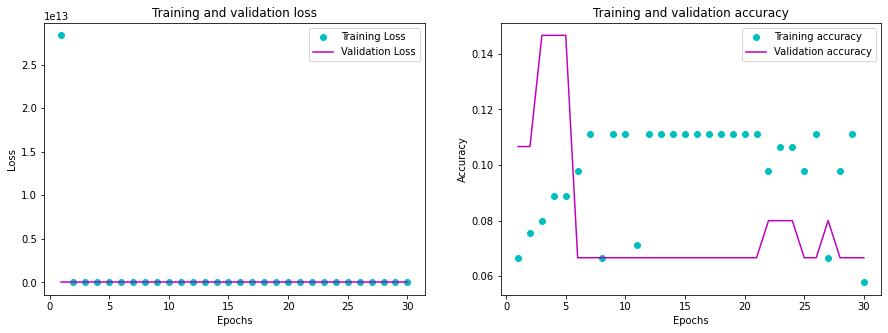

In [108]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [109]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 81ms/step - loss: 2.3042 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [110]:
model.save("model/fit-Adamax-VGG19-0.01.h5")

# intento 3

In [111]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-Adamax-VGG19-0.001.h5")

In [112]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [113]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 179ms/step - loss: 22.3309 - accuracy: 0.0893 - val_loss: 2.3271 - val_accuracy: 0.0667
Epoch 2/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3125 - accuracy: 0.0775 - val_loss: 2.3043 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 170ms/step - loss: 2.3021 - accuracy: 0.1050 - val_loss: 2.3049 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 170ms/step - loss: 2.3033 - accuracy: 0.0783 - val_loss: 2.3059 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3027 - accuracy: 0.1024 - val_loss: 2.3064 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3012 - accuracy: 0.1347 - val_loss: 2.3075 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 171ms/step - loss: 2.3000 - accuracy: 0.1235 - val_loss: 2.3078 - val_accuracy: 0.0667
Epoch

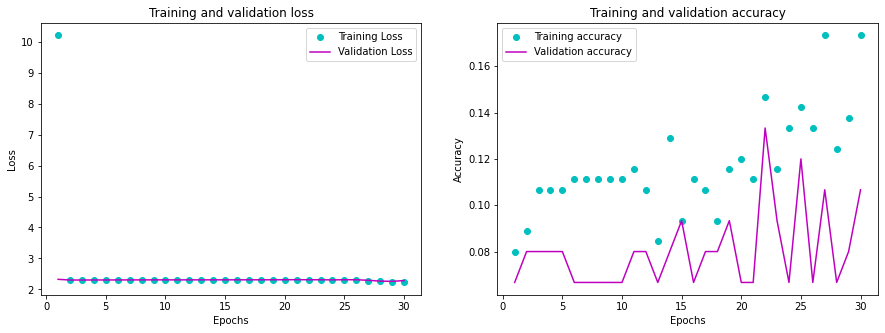

In [114]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [115]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 82ms/step - loss: 2.2553 - accuracy: 0.1300
Confusion_matrix:  tf.Tensor(
[[ 0  0  7  0  0  0  0  0  2  1]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  1]
 [ 0  0  4  0  0  0  0  0  4  2]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  1  4]
 [ 0  0  9  0  0  0  0  0  1  0]
 [ 0  0  8  0  0  0  0  0  1  1]
 [ 0  0  3  0  0  0  0  0  2  5]
 [ 0  0  6  0  0  0  0  0  2  2]], shape=(10, 10), dtype=int32)


In [116]:
model.save("model/fit-Adamax-VGG19-0.001.h5")

# intento 4

In [117]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-Adamax-VGG19-0.0001.h5")

In [118]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [119]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 182ms/step - loss: 2.4653 - accuracy: 0.0857 - val_loss: 2.3242 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3398 - accuracy: 0.1009 - val_loss: 2.3117 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 4s 173ms/step - loss: 2.3092 - accuracy: 0.0970 - val_loss: 2.3047 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 4s 173ms/step - loss: 2.2980 - accuracy: 0.1864 - val_loss: 2.3037 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 4s 173ms/step - loss: 2.2955 - accuracy: 0.1380 - val_loss: 2.3035 - val_accuracy: 0.0533
Epoch 6/30
23/23 [==============================] - 4s 173ms/step - loss: 2.2950 - accuracy: 0.1071 - val_loss: 2.3011 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 4s 173ms/step - loss: 2.2884 - accuracy: 0.0948 - val_loss: 2.2777 - val_accuracy: 0.0933
Epoch 

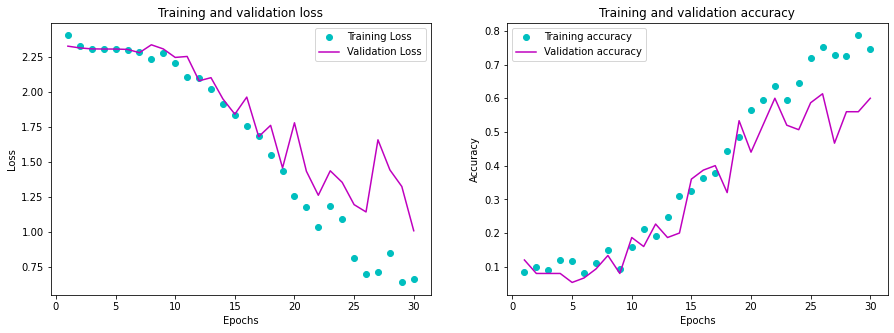

In [120]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [121]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 83ms/step - loss: 1.0885 - accuracy: 0.5700
Confusion_matrix:  tf.Tensor(
[[3 0 0 1 0 0 2 1 0 3]
 [0 7 0 0 1 0 0 0 0 2]
 [0 0 7 0 0 0 1 2 0 0]
 [0 0 0 8 0 1 0 0 1 0]
 [0 0 0 0 8 0 0 0 2 0]
 [0 0 0 1 0 2 0 1 3 3]
 [0 3 1 0 0 1 5 0 0 0]
 [0 0 0 5 0 0 0 5 0 0]
 [0 0 0 1 0 2 0 0 7 0]
 [2 1 0 0 0 2 0 0 0 5]], shape=(10, 10), dtype=int32)


In [122]:
model.save("model/fit-Adamax-VGG19-0.0001.h5")

# intento 5

In [123]:
baseModel = VGG19(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/base-Adamax-VGG19-0.00001.h5")

In [124]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [125]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 5s 183ms/step - loss: 2.3837 - accuracy: 0.1170 - val_loss: 2.2792 - val_accuracy: 0.1600
Epoch 2/30
23/23 [==============================] - 4s 174ms/step - loss: 2.1882 - accuracy: 0.2349 - val_loss: 2.2219 - val_accuracy: 0.0933
Epoch 3/30
23/23 [==============================] - 4s 173ms/step - loss: 2.0892 - accuracy: 0.2366 - val_loss: 2.1203 - val_accuracy: 0.2400
Epoch 4/30
23/23 [==============================] - 4s 175ms/step - loss: 1.9984 - accuracy: 0.3835 - val_loss: 1.9995 - val_accuracy: 0.3200
Epoch 5/30
23/23 [==============================] - 4s 173ms/step - loss: 1.8099 - accuracy: 0.4049 - val_loss: 1.9278 - val_accuracy: 0.3867
Epoch 6/30
23/23 [==============================] - 4s 173ms/step - loss: 1.6762 - accuracy: 0.4757 - val_loss: 1.8532 - val_accuracy: 0.4267
Epoch 7/30
23/23 [==============================] - 4s 172ms/step - loss: 1.5145 - accuracy: 0.5984 - val_loss: 1.7321 - val_accuracy: 0.4800
Epoch 

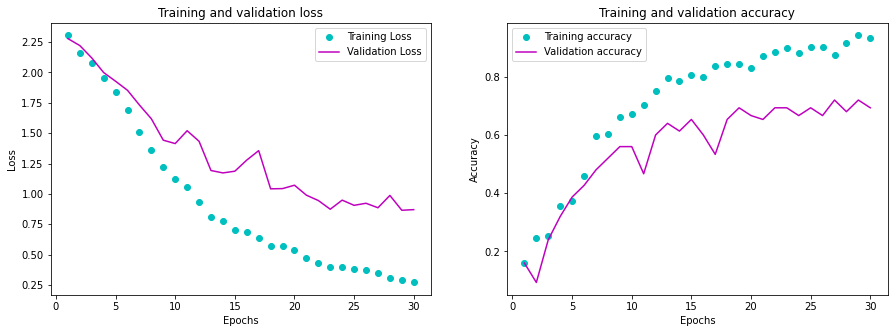

In [126]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [127]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 83ms/step - loss: 0.7865 - accuracy: 0.7200
Confusion_matrix:  tf.Tensor(
[[ 6  0  0  0  1  1  1  0  0  1]
 [ 2  8  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0  0]
 [ 0  0  0  7  1  1  0  0  1  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 1  0  0  0  1  4  0  0  2  2]
 [ 0  2  1  0  0  1  6  0  0  0]
 [ 0  0  0  3  0  0  0  7  0  0]
 [ 0  0  0  1  0  0  0  0  9  0]
 [ 1  2  0  0  0  1  0  0  0  6]], shape=(10, 10), dtype=int32)


In [128]:
model.save("model/fit-Adamax-VGG19-0.00001.h5")